In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import colormaps
import matplotlib.patches as patches
import matplotlib.lines as lines
import seaborn as sns
from matplotlib.gridspec import GridSpec

filenames = ['random_1', 'random_2', 'random_3', 'random_4', 'random_5', 'random_6', 'random_7', 'random_8', 'random_9', 'random_10', 'random_11', 'random_12', 'random_13', 'random_14', 'random_15', 'random_16', 'random_17', 'random_18', 'random_19', 'random_20', 'clustered_1', 'clustered_2', 'clustered_3', 'clustered_4', 'clustered_5', 'clustered_6', 'clustered_7', 'clustered_8', 'clustered_9', 'clustered_10', 'clustered_11', 'clustered_12', 'clustered_13', 'clustered_14', 'clustered_15', 'clustered_16', 'clustered_17', 'clustered_18', 'clustered_19', 'clustered_20']
path = "../blossom/hpc/outputs/"
sample_times = [252, 415, 310, 192, 241, 308, 338, 231, 241, 233, 241, 330, 246, 246, 161, 327, 158, 218, 291, 431, 206, 185, 307, 258, 287, 244, 335, 291, 151, 206, 167, 356, 208, 224, 271, 181, 179, 279, 305, 246]
organism_group_labels = ["Bacteria", "Fungi", "Root-feeding Nematodes", "Bacterivorous Nematodes", "Fungivorous Nematodes", "Omnivorous Nematodes", "Fungivorous Mites", "Omnivorous Mites", "Collembolans"]
x_max = 400
y_max = 400

In [17]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.style.use("seaborn-v0_8-whitegrid")

def rand_jitter(arr):
    if(len(arr)):
        stdev = .00025 * (max(arr) - min(arr))
        return arr + np.random.randn(len(arr)) * stdev
    return arr

In [18]:
idx = 0
filename = filenames[idx]

df = pd.read_csv(path + filename + ".csv")
n = len(df["type"].unique())
colors = colormaps['tab10'].colors
counts_per_type = df.value_counts(['type', 'tick'])

sample_locations = [(50, 50), (50, 150), (50, 250), (50, 350), (125, 150), (175, 250), (275, 150), (225, 250), (350, 50), (350, 150), (350, 250), (350, 350)]
sample_locations = [(50, 50), (50, 150), (50, 250), (50, 350), (150, 50), (150, 150), (150, 250), (150, 350), (250, 50), (250, 150), (250, 250), (250, 350),  (350, 50), (350, 150), (350, 250), (350, 350)]

In [19]:
def plot_von_neumann(ax, center_x, center_y, ranges):
    # Define a list of colors that contrast well with orange
    colors_legend = ['blue', 'teal', 'darkblue', 'darkviolet', 'indigo']  # Adjusted colors
    colors_legend = sns.color_palette("mako", 5)
    
    # Plot only the outer boundary cells of the Von Neumann neighborhood
    # The outer boundary cells form a diamond shape.
    for i in reversed(range(len(ranges))):
        r = ranges[i]
        # Define the color for the current range
        color = colors_legend[i % len(colors_legend)]
        
        # Top and bottom edges of the diamond
        for dx in range(-r, r + 1):
            dy = r - abs(dx)
            ax.add_patch(patches.Rectangle((center_x + dx - 0.5, center_y + dy - 0.5), 1, 1, edgecolor=color, facecolor='none', linewidth=3))
            ax.add_patch(patches.Rectangle((center_x + dx - 0.5, center_y - dy - 0.5), 1, 1, edgecolor=color, facecolor='none', linewidth=3))
        
        # Left and right edges of the diamond
        for dy in range(-r + 1, r):
            dx = r - abs(dy)
            ax.add_patch(patches.Rectangle((center_x - dx - 0.5, center_y + dy - 0.5), 1, 1, edgecolor=color, facecolor='none', linewidth=3))
            ax.add_patch(patches.Rectangle((center_x + dx - 0.5, center_y + dy - 0.5), 1, 1, edgecolor=color, facecolor='none', linewidth=3))

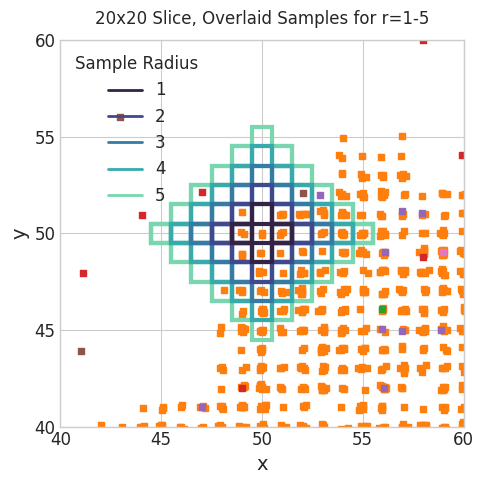

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
i=0

df1 = df[df["tick"] == sample_times[idx]]
for t in np.unique(df1["type"]):
    subset_type = df1[df1['type'] == t]
    ax.scatter(rand_jitter(subset_type['x']), rand_jitter(subset_type['y']), color=colors[t], label=t, s=15, marker='s')
# Add Von Neumann neighborhoods for all sample locations
for (loc_x, loc_y) in sample_locations:
    plot_von_neumann(ax, loc_x, loc_y, range(1, 6))    

ax.set_title(f'20x20 Slice, Overlaid Samples for r=1-5', y=1.02)
ax.set_xlabel('x')
ax.set_yticks([40, 45, 50, 55, 60])
ax.set_xticks([40, 45, 50, 55, 60])
ax.set_yticklabels([40, 45, 50, 55, 60])
ax.set_xticklabels([40, 45, 50, 55, 60])
ax.set_ylabel('y')
ax.set_xlim(sample_locations[i][0] - 10, sample_locations[i][0] + 10)
ax.set_ylim(sample_locations[i][1] - 10, sample_locations[i][1] + 10)


colors_legend = ['blue', 'teal', 'darkblue', 'darkviolet', 'indigo']
colors_legend = sns.color_palette("mako", 5)
# Create a legend with one entry per range
legend_handles = [lines.Line2D([0], [0], color=colors_legend[i], lw=2) for i in range(5)]
range_labels = [str(r) for r in range(1,6)]
ax.legend(legend_handles, range_labels, title='Sample Radius', loc='upper left')

plt.tight_layout()
plt.savefig('6-sample-diameter.pdf')
plt.show()

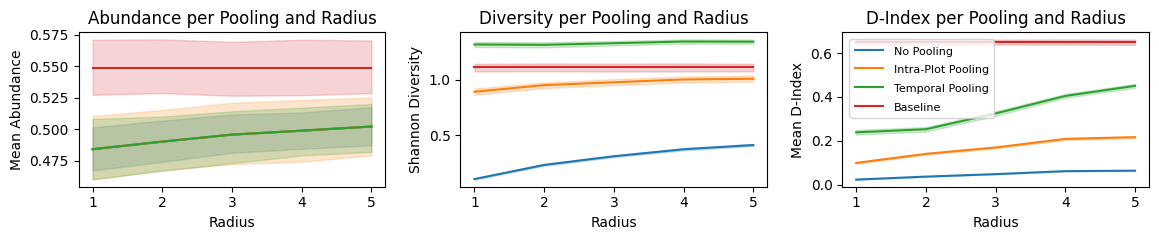

In [7]:
fig = plt.figure(figsize=(11.69,2.5))

gs = GridSpec(1, 3)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

df1 = pd.read_csv('../experiments/prep_out/estimated_abundances_reg.csv')
df2 = pd.read_csv('../experiments/prep_out/estimated_abundances_w.csv')
df_n = pd.concat([df1, df2])
df_n['Mean Abundance'] = df_n[['0', '1', '2', '3', '4', '5', '6', '7', '8']].mean(axis=1)
df_n['Pooling'] = 'No Pooling'

df1 = pd.read_csv('../experiments/prep_out/estimated_abundances_reg.csv')
df2 = pd.read_csv('../experiments/prep_out/estimated_abundances_w.csv')
df_i = pd.concat([df1, df2])
df_i = df_i.groupby(['filename', 'r', 'sample_time'], as_index=False).agg({'0': ['mean'], '1': ['mean'],'2': ['mean'],'3': ['mean'],'4': ['mean'],'5': ['mean'],'6': ['mean'],'7': ['mean'],'8': ['mean']})
df_i.columns = df_i.columns.get_level_values(0)
df_i['Mean Abundance'] = df_i[['0', '1', '2', '3', '4', '5', '6', '7', '8']].mean(axis=1)
df_i['Pooling'] = 'Intra-Plot Pooling'

df1 = pd.read_csv('../experiments/prep_out/estimated_abundances_reg.csv')
df2 = pd.read_csv('../experiments/prep_out/estimated_abundances_w.csv')
df_t = pd.concat([df1, df2])
df_t = df_t.groupby(['filename', 'r'], as_index=False).agg({'0': ['mean'], '1': ['mean'],'2': ['mean'],'3': ['mean'],'4': ['mean'],'5': ['mean'],'6': ['mean'],'7': ['mean'],'8': ['mean']})
df_t.columns = df_t.columns.get_level_values(0)
df_t['Mean Abundance'] = df_t[['0', '1', '2', '3', '4', '5', '6', '7', '8']].mean(axis=1)
df_t['Pooling'] = 'Temporal Pooling'

df1 = pd.read_csv('../experiments/prep_out/baseline_abundances.csv')
df1['Mean Abundance'] = df1[['0', '1', '2', '3', '4', '5', '6', '7', '8']].mean(axis=1)
df1 = pd.concat([df1.assign(r=c) for c in [1, 2, 3, 4, 5]], ignore_index=True)
df1['Pooling'] = 'Baseline'

df = pd.concat([df_n, df_i, df_t, df1])

g = sns.lineplot(x='r', y='Mean Abundance', hue='Pooling', data=df, ax=ax1, legend=False)
g.set_xlabel('Radius')
g.set_xticks([1, 2, 3, 4, 5])
ax1.set_title('Abundance per Pooling and Radius')

df1 = pd.read_csv('../experiments/prep_out/estimated_diversity_indices_sample_reg.csv')
df2 = pd.read_csv('../experiments/prep_out/estimated_diversity_indices_sample_w.csv')
df_n = pd.concat([df1, df2])
df_n['Pooling'] = 'No Pooling'

df1 = pd.read_csv('../experiments/prep_out/estimated_diversity_indices_plot_reg.csv')
df2 = pd.read_csv('../experiments/prep_out/estimated_diversity_indices_plot_w.csv')
df_i = pd.concat([df1, df2])
df_i['Pooling'] = 'Intra-Plot Pooling'

df1 = pd.read_csv('../experiments/prep_out/estimated_diversity_indices_temporal_reg.csv')
df2 = pd.read_csv('../experiments/prep_out/estimated_diversity_indices_temporal_w.csv')
df_t = pd.concat([df1, df2])
df_t['Pooling'] = 'Temporal Pooling'

df1 = pd.read_csv('../experiments/prep_out/baseline_diversity_indices.csv')
df1 = pd.concat([df1.assign(r=c) for c in [1, 2, 3, 4, 5]], ignore_index=True)
df1['Pooling'] = 'Baseline'

df = pd.concat([df_n, df_i, df_t, df1])

#df['mean'] = df[['0', '1', '2', '3', '4', '5', '6', '7', '8']].mean(axis=1)
g = sns.lineplot(x='r', y='shannon', hue='Pooling', data=df, ax=ax2, legend=False)
g.set_xlabel('Radius')
g.set_ylabel('Shannon Diversity')
g.set_xticks([1, 2, 3, 4, 5])
ax2.set_title('Diversity per Pooling and Radius')

df1 = pd.read_csv('../experiments/prep_out/estimated_d_index_sample_reg.csv')
df2 = pd.read_csv('../experiments/prep_out/estimated_d_index_sample_w.csv')
df_n = pd.concat([df1, df2])
df_n['Mean D-Index'] = df_n[['0', '1', '2', '3', '4', '5', '6', '7', '8']].mean(axis=1)
df_n['Pooling'] = 'No Pooling'

df1 = pd.read_csv('../experiments/prep_out/estimated_d_index_plot_reg.csv')
df2 = pd.read_csv('../experiments/prep_out/estimated_d_index_plot_w.csv')
df_i = pd.concat([df1, df2])
df_i['Mean D-Index'] = df_i[['0', '1', '2', '3', '4', '5', '6', '7', '8']].mean(axis=1)
df_i['Pooling'] = 'Intra-Plot Pooling'

df1 = pd.read_csv('../experiments/prep_out/estimated_d_index_temporal_reg.csv')
df2 = pd.read_csv('../experiments/prep_out/estimated_d_index_temporal_w.csv')
df_t = pd.concat([df1, df2])
df_t['Mean D-Index'] = df_t[['0', '1', '2', '3', '4', '5', '6', '7', '8']].mean(axis=1)
df_t['Pooling'] = 'Temporal Pooling'

df1 = pd.read_csv('../experiments/prep_out/baseline_d_index.csv')
df1['Mean D-Index'] = df1[['0', '1', '2', '3', '4', '5', '6', '7', '8']].mean(axis=1)
df1 = pd.concat([df1.assign(r=c) for c in [1, 2, 3, 4, 5]], ignore_index=True)
df1['Pooling'] = 'Baseline'

df = pd.concat([df_n, df_i, df_t, df1])

g= sns.lineplot(x='r', y='Mean D-Index', hue='Pooling', data=df, ax=ax3)
g.set_xlabel('Radius')
g.set_xticks([1, 2, 3, 4, 5])
g.legend_.set_title('')
new_labels = ['No Pooling', 'Intra-Plot Pooling', 'Temporal Pooling', 'Baseline']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)
    t.set_fontsize('8')
ax3.set_title('D-Index per Pooling and Radius')


plt.tight_layout()
plt.savefig("6-actual-estimates.pdf", format="pdf", bbox_inches="tight")
plt.show()

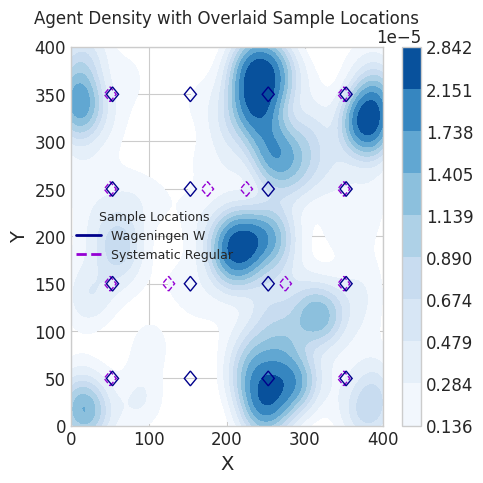

In [14]:
# Define the sampling locations
sys_reg_locations = [(50, 50), (50, 150), (50, 250), (50, 350), (125, 150), (175, 250), (275, 150), (225, 250), (350, 50), (350, 150), (350, 250), (350, 350)]
wageningen_w_locations = [(50, 50), (50, 150), (50, 250), (50, 350), (150, 50), (150, 150), (150, 250), (150, 350), (250, 50), (250, 150), (250, 250), (250, 350),  (350, 50), (350, 150), (350, 250), (350, 350)]
df1 = df[df["tick"] == 400]#sample_times[idx]]
def plot_von_neumann(ax, center_x, center_y, r, color, linestyle):
    # Top and bottom edges
    ax.add_patch(patches.Rectangle((center_x + 0.25, center_y - 8), 11, 11, angle=45, edgecolor=color, facecolor='none', linewidth=1, linestyle=linestyle))
        
# Create the heatmap for agent density
plt.figure(figsize=(5, 5))
ax = plt.gca()
# Plot the density heatmap
sns.kdeplot(data=df1, x='x', y='y', cmap='Blues', fill=True, ax=ax, cbar=True)

# Overlay Systematic Regular Von Neumann neighborhoods with radius 5
for (x, y) in sys_reg_locations:
    plot_von_neumann(ax, x, y, r=5, color='darkviolet', linestyle='--')  # Red dashed lines for Systematic Regular grid

# Overlay Wageningen W Von Neumann neighborhoods with radius 5
for (x, y) in wageningen_w_locations:
    plot_von_neumann(ax, x + 3, y, r=5, color='darkblue', linestyle='-')  # Green solid lines for Wageningen W grid

# Set plot limits and labels
ax.set_xlim(0, 400)
ax.set_ylim(0, 400)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Agent Density with Overlaid Sample Locations', y=1.04)

legend_handles = [lines.Line2D([0], [0], color='darkblue', lw=2, linestyle='-'), lines.Line2D([0], [0], color='darkviolet', lw=2, linestyle='--')]
range_labels = ['Wageningen W', 'Systematic Regular']
ax.legend(legend_handles, range_labels, title='Sample Locations', loc=(0, 0.42), prop={'size': 9}, title_fontsize=9)

# Show plot
plt.tight_layout()
plt.savefig('6-sampling-locs.pdf')
plt.show()

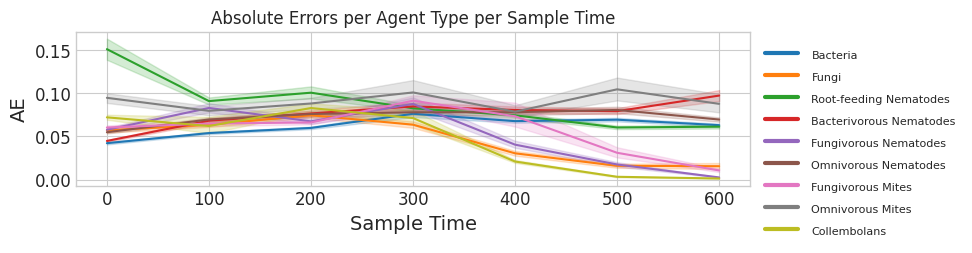

In [7]:
df1 = pd.read_csv('../experiments/analysis_out/abundances_sample_w_type.csv')
df1['distribution'] = pd.Series('clustered', index=df1.index).mask(df1['filename'].str.contains('random'), 'random')
df1['sampling_strat'] = 'w'
df2 = pd.read_csv('../experiments/analysis_out/abundances_sample_reg_type.csv')
df2['distribution'] = pd.Series('clustered', index=df2.index).mask(df2['filename'].str.contains('random'), 'random')
df2['sampling_strat'] = 'reg'
# Combine df1 and df2 into a single DataFrame
df_combined = pd.concat([df1, df2])
df_combined['setup'] = df_combined["distribution"] + df_combined["sampling_strat"]

fig = plt.figure(figsize=(8.69,2))

g=sns.lineplot(x='sample_time', y='ae', hue='type_id', palette=sns.color_palette("tab10")[:9], data=df_combined)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Sample Time')
g.set_ylabel('AE')
for lh in g.legend_.legend_handles:
    lh.set_linewidth('3')
g.legend_.set_title('')
new_labels = ["Bacteria", "Fungi", "Root-feeding Nematodes", "Bacterivorous Nematodes", "Fungivorous Nematodes", "Omnivorous Nematodes", "Fungivorous Mites", "Omnivorous Mites", "Collembolans"]
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)
    t.set_fontsize('8')
g.set_title('Absolute Errors per Agent Type per Sample Time')
plt.savefig("6-sample_time.pdf", format="pdf", bbox_inches="tight")

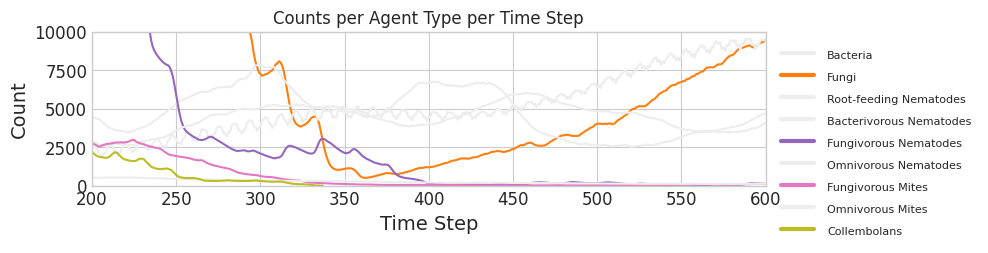

In [12]:
df = pd.read_csv('../blossom/hpc/outputs/clustered_1.csv')
fig = plt.figure(figsize=(8.69,2))
cp = [(0.9295040369088812, 0.9295040369088812, 0.9295040369088812), (1.0, 0.4980392156862745, 0.054901960784313725), (0.9295040369088812, 0.9295040369088812, 0.9295040369088812), (0.9295040369088812, 0.9295040369088812, 0.9295040369088812), (0.5803921568627451, 0.403921568627451, 0.7411764705882353), (0.9295040369088812, 0.9295040369088812, 0.9295040369088812), (0.8901960784313725, 0.4666666666666667, 0.7607843137254902), (0.9295040369088812, 0.9295040369088812, 0.9295040369088812), (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)]


g=sns.lineplot(x='tick', y='x', hue='type', palette=cp, data=df.groupby(['type', 'tick']).count())
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.set_xlabel('Time Step')
g.set_ylabel('Count')
g.set_ybound(0, 10000)
for lh in g.legend_.legend_handles:
    lh.set_linewidth('3')
g.legend_.set_title('')
new_labels = ["Bacteria", "Fungi", "Root-feeding Nematodes", "Bacterivorous Nematodes", "Fungivorous Nematodes", "Omnivorous Nematodes", "Fungivorous Mites", "Omnivorous Mites", "Collembolans"]
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)
    t.set_fontsize('8')
g.set_xbound(200, 600)
g.set_title('Counts per Agent Type per Time Step')
plt.savefig("6-sample_counts.pdf", format="pdf", bbox_inches="tight")

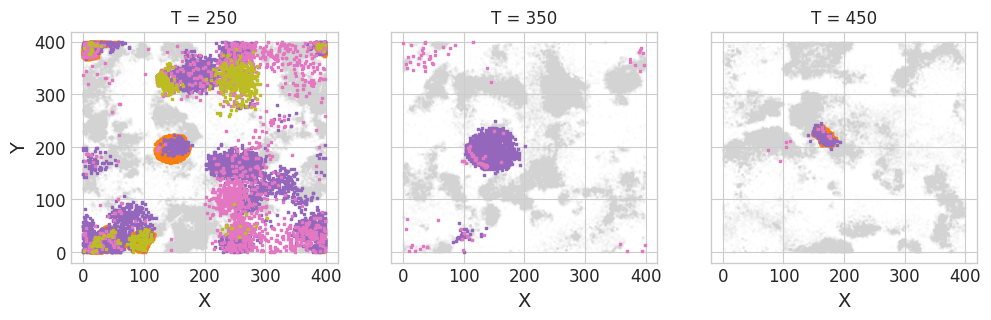

In [13]:
from matplotlib import colormaps
colors = colormaps['tab10'].colors
df = pd.read_csv('../blossom/hpc/outputs/clustered_1.csv')
fig, ax = plt.subplots(1, 3, figsize=(11.69, 3))

df1 = df[df["tick"] == 250]
df2 = df[df["tick"] == 350]
df3 = df[df["tick"] == 450]

for t in np.unique(df1["type"]):
    subset_type = df1[df1['type'] == t]
    if t in [1, 4, 6, 8]:
        ax[0].scatter(rand_jitter(subset_type['x']), rand_jitter(subset_type['y']), color=colors[t], label=t, s=1, marker='s')
    else:
        ax[0].scatter(rand_jitter(subset_type['x']), rand_jitter(subset_type['y']), color='lightgrey', label=t, s=1, marker='s', alpha=0.005)
ax[0].set_title(f'T = 250')
ax[0].set_xlabel('X')
ax[0].set_xticks([0, 100, 200, 300, 400])
ax[0].set_ylabel('Y')

for t in np.unique(df2["type"]):
    subset_type = df2[df2['type'] == t]
    if t in [1, 4, 6, 8]:
        ax[1].scatter(rand_jitter(subset_type['x']), rand_jitter(subset_type['y']), color=colors[t], label=t, s=1, marker='s')
    else:
        ax[1].scatter(rand_jitter(subset_type['x']), rand_jitter(subset_type['y']), color='lightgrey', label=t, s=1, marker='s', alpha=0.005)
ax[1].set_title(f'T = 350')
ax[1].set_xlabel('X')
ax[1].set_xticks([0, 100, 200, 300, 400])
ax[1].set_ylabel('')
ax[1].set_yticklabels([])

for t in np.unique(df3["type"]):
    subset_type = df3[df3['type'] == t]
    if t in [1, 4, 6, 8]:
        ax[2].scatter(rand_jitter(subset_type['x']), rand_jitter(subset_type['y']), color=colors[t], label=t, s=1, marker='s')
    else:
        ax[2].scatter(rand_jitter(subset_type['x']), rand_jitter(subset_type['y']), color='lightgrey', label=t, s=1, marker='s', alpha=0.005)
ax[2].set_title(f'T = 450')
ax[2].set_xlabel('X')
ax[2].set_xticks([0, 100, 200, 300, 400])
ax[2].set_ylabel('')
ax[2].set_yticklabels([])

plt.savefig("6-sample-time-hms.pdf", format="pdf", bbox_inches="tight")
plt.savefig("6-sample-time-hms.png", format="png", bbox_inches="tight")

In [1]:
df1 = pd.read_csv('../experiments/analysis_out/abundances_sample_w_2.csv')
df1['distribution'] = pd.Series('clustered', index=df1.index).mask(df1['filename'].str.contains('random'), 'random')
df1['sampling_strat'] = 'w'
df2 = pd.read_csv('../experiments/analysis_out/abundances_sample_reg_2.csv')
df2['distribution'] = pd.Series('clustered', index=df2.index).mask(df2['filename'].str.contains('random'), 'random')
df2['sampling_strat'] = 'reg'
# Combine df1 and df2 into a single DataFrame
df_combined = pd.concat([df1, df2])
df_combined['setup'] = df_combined["distribution"] + df_combined["sampling_strat"]

df1 = pd.read_csv('../experiments/analysis_out/abundances_plot_w_2.csv')
df1['distribution'] = pd.Series('clustered', index=df1.index).mask(df1['filename'].str.contains('random'), 'random')
df1['sampling_strat'] = 'w'
df2 = pd.read_csv('../experiments/analysis_out/abundances_plot_reg_2.csv')
df2['distribution'] = pd.Series('clustered', index=df2.index).mask(df2['filename'].str.contains('random'), 'random')
df2['sampling_strat'] = 'reg'
# Combine df1 and df2 into a single DataFrame
df_combined_2 = pd.concat([df1, df2])
df_combined_2['setup'] = df_combined_2["distribution"] + df_combined_2["sampling_strat"]

df1 = pd.read_csv('../experiments/analysis_out/abundances_temporal_w_2.csv')
df1['distribution'] = pd.Series('clustered', index=df1.index).mask(df1['filename'].str.contains('random'), 'random')
df1['sampling_strat'] = 'w'
df2 = pd.read_csv('../experiments/analysis_out/abundances_temporal_reg_2.csv')
df2['distribution'] = pd.Series('clustered', index=df2.index).mask(df2['filename'].str.contains('random'), 'random')
df2['sampling_strat'] = 'reg'
# Combine df1 and df2 into a single DataFrame
df_combined_3 = pd.concat([df1, df2])
df_combined_3['setup'] = df_combined_3["distribution"] + df_combined_3["sampling_strat"]

fig = plt.figure(figsize=(11.69,7.5))

gs = GridSpec(3, 2, width_ratios=[4, 3], height_ratios=[1, 1, 1])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])
ax6 = fig.add_subplot(gs[5])

# Plot [mae, w]
g=sns.boxplot(x='r', y='mser', hue='setup', palette=sns.color_palette("Set2")[:4], data=df_combined, ax=ax1, legend=True)
ax1.set_title('No Pooling: Effect of Radius on MSEr')
ax1.set_xlabel('Radius')
ax1.set_ylabel('MSEr')
#ax1.set_ybound(0, 5)
g.legend_.set_title('')
new_labels = ['Random W', 'Clustered W', 'Random R', 'Clustered R']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)
    t.set_fontsize('8')


df1 = pd.read_csv("../experiments/analysis_out/abundances_sample_w_type.csv")
df2 = pd.read_csv("../experiments/analysis_out/abundances_sample_reg_type.csv")
df = pd.concat([df1, df2])
data = df.nlargest(20, columns='ae')
g = sns.swarmplot(x='type_id', y='ae', hue='type_id', palette=[sns.color_palette("tab10")[i] for i in [6, 7, 8]], data=data, ax=ax2, legend=False)
ax2.set_title('No Pooling: 20 Largest Outliers')
ax2.set_xlabel('Agent Type')
ax2.set_ylabel('Error')

# Plot [mae, w]
sns.boxplot(x='r', y='mser', hue='setup', palette=sns.color_palette("Set2")[:4], data=df_combined_2, ax=ax3, legend=False)
ax3.set_title('Intra Plot Pooling: Effect of Radius on MSEr')
ax3.set_xlabel('Radius')
ax3.set_ylabel('MSEr')

df1 = pd.read_csv("../experiments/analysis_out/abundances_plot_w_type.csv")
df2 = pd.read_csv("../experiments/analysis_out/abundances_plot_reg_type.csv")
df = pd.concat([df1, df2])
data = df.nlargest(20, columns='ae')
g = sns.swarmplot(x='type_id', y='ae', hue='type_id', palette=[sns.color_palette("tab10")[i] for i in [2, 6, 7, 8]], data=data, ax=ax4, legend=False)
ax4.set_title('Intra-Plot Pooling: 20 Largest Outliers')
ax4.set_xlabel('Agent Type')
ax4.set_ylabel('Error')

# Plot [mae, w]
sns.boxplot(x='r', y='mser', hue='setup', palette=sns.color_palette("Set2")[:4], data=df_combined_3, ax=ax5, legend=False)
ax5.set_title('Temporal Pooling: Effect of Radius on MSEr')
ax5.set_xlabel('Radius')
ax5.set_ylabel('MSEr')

df1 = pd.read_csv("../experiments/analysis_out/abundances_temporal_w_type.csv")
df2 = pd.read_csv("../experiments/analysis_out/abundances_temporal_reg_type.csv")
df = pd.concat([df1, df2])
data = df.nlargest(20, columns='ae')
g = sns.swarmplot(x='type_id', y='ae', hue='type_id', palette=[sns.color_palette("tab10")[i] for i in [2, 3, 6, 7, 8]], data=data, ax=ax6, legend=False)
ax6.set_title('Temporal Pooling: 20 Largest Outliers')
ax6.set_xlabel('Agent Type')
ax6.set_ylabel('Error')

# Adjust layout to make sure plots are neatly arranged
plt.tight_layout()
plt.savefig("6-ab-outliers.pdf", format="pdf", bbox_inches="tight")
plt.savefig("6-ab-outliers.png", format="png", bbox_inches="tight")
plt.show()

NameError: name 'pd' is not defined